In [1]:
# Import Packaes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning packages
from sklearn.preprocessing import StandardScaler  # Maybe use MinMaxScaler?
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# import warnings
# warnings.filterwarnings("ignore")

# Prevents Pandas Copy Warning
pd.set_option("mode.copy_on_write", True)

## Exploratory Data Analysis

In [ ]:
import pandas as pd

# Load in the data
# credit_card_data = pd.read_csv("data/creditcard_2023.csv.zip")
credit_card_data = pd.read_csv(
    "https://drive.google.com/uc?id=157IFLdAsOKXYCzglKbusxmc8Mvz3_32e/view?usp=sharing"
)
# # Inspect the data
# display(credit_card_data.sample(10))

# print(f"Credit card dataset dimensions: {credit_card_data.shape}")

# # Information about each variable
# print("")

# display(credit_card_data.info())

# # Check for missing values
# display(credit_card_data.isna().sum())

KeyboardInterrupt: 

After loading in the dataset we observe the following:

- There are 284,807 observation and 31 variables.
- All variables are floats types except for `Class` which is an integer
- There are no missing values

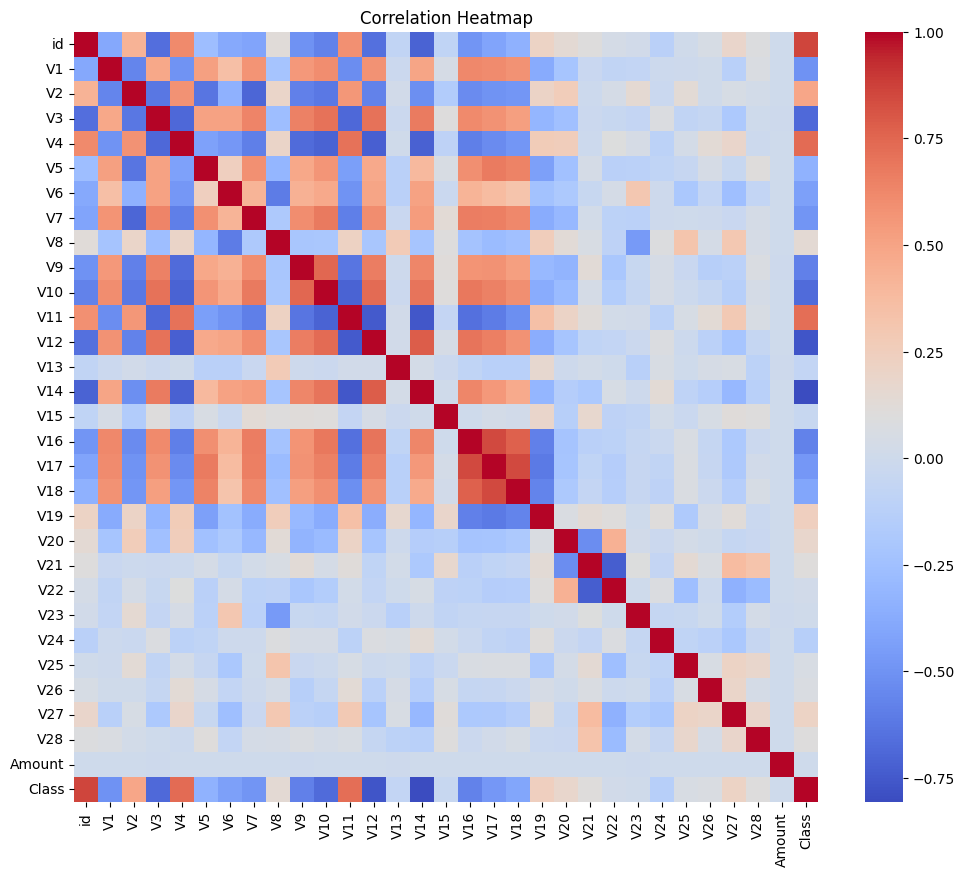

In [3]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(credit_card_data.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

Split data and scale. 

In [4]:
# Separate features and target
X = credit_card_data.drop("Class", axis=1)
y = credit_card_data["Class"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The block below can take longer than 5 mins to run depending on you computer specs.

In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        f"{model.__class__.__name__} Classification Report:\n",
        classification_report(y_test, y_pred),
    )
    print(
        f"{model.__class__.__name__} ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}\n"
    )


# Logistic Regression
logistic_model = LogisticRegression()
evaluate_model(logistic_model, X_train_scaled, y_train, X_test_scaled, y_test)

# Decision Tree
dtree_model = DecisionTreeClassifier()
evaluate_model(dtree_model, X_train, y_train, X_test, y_test)

# Random Forest with parallel processing and fewer estimators
rforest_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
evaluate_model(rforest_model, X_train, y_train, X_test, y_test)

# # Gradient Boosting with fewer estimators
gboost_model = GradientBoostingClassifier(n_estimators=50)
evaluate_model(gboost_model, X_train, y_train, X_test, y_test)

# XGBoost with fewer estimators and parallel processing
xgb_model = XGBClassifier(
    n_estimators=50, eval_metric="logloss", n_jobs=-1, random_state=42
)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

LogisticRegression ROC AUC Score: 0.9998071705165726

DecisionTreeClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

DecisionTreeClassifier ROC AUC Score: 0.9995955190545699

RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

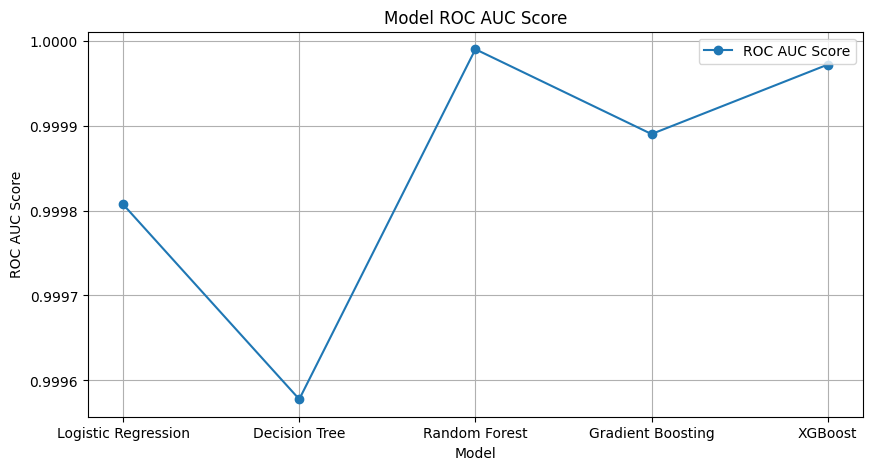

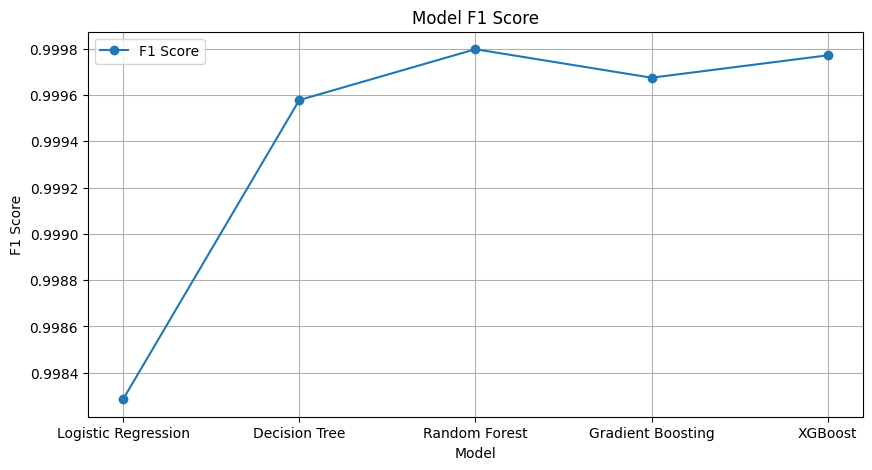

In [ ]:
# Define a function to store performance metrics for each model
def evaluate_model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Check if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        auc_score = (
            None  # Or use a default score like 0.5 if predict_proba is not available
        )

    f1_score = report["weighted avg"]["f1-score"]
    return auc_score, f1_score


# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
}

# Initialize lists to store results
auc_scores = []
f1_scores = []
model_names = []

# Evaluate each model
for name, model in models.items():
    auc, f1 = evaluate_model_performance(
        model, X_train_scaled, y_train, X_test_scaled, y_test
    )
    auc_scores.append(auc)
    f1_scores.append(f1)
    model_names.append(name)

# Store results in a DataFrame
results = pd.DataFrame(
    {"Model": model_names, "ROC AUC Score": auc_scores, "F1 Score": f1_scores}
)

# Plotting metrics
metrics = {"ROC AUC Score": auc_scores, "F1 Score": f1_scores}
for metric_name, scores in metrics.items():
    plt.figure(figsize=(10, 5))
    plt.plot(model_names, scores, marker="o", label=metric_name)
    plt.xlabel("Model")
    plt.ylabel(metric_name)
    plt.title(f"Model {metric_name}")
    plt.legend()
    plt.grid(True)
    plt.show()